In [1]:
import torch as t
import numpy as np
import random
import matplotlib as mpl 
import matplotlib.pyplot as plt


In [2]:
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.latex.preamble"] = "\\usepackage{amssymb}"

In [3]:
def remove_ticklines(ax):
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

In [5]:
###
#   Set device
###

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

###
#   Define Moore NBH function
###

MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    _, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0)).flatten(end_dim=1)
    idx_pad = cell_pixel_coords[:, 0].repeat_interleave(9).flatten().unsqueeze(-1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    idc, counts = t.unique(idx_pad, return_counts=True)
    return t.split(t.concatenate((idx_pad, nbh_coords), dim=-1), split_size_or_sections=counts.tolist())

In [86]:
STEP_SIZES = t.tensor([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)], device=device)
def model(batch, temperature):
    """Performs one sampling step of the CPM Random-Walk model.

    Args:
        batch: Batch of CPM-R grids
        temperature: The model temperature

    Returns:
        The batch of grids, mapped to the next timestep.
    """
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = t.vstack(list(map(random.choice, frontiers))).type(t.long)
    
    p_f = np.sqrt(2.)
    p_side = (p_f - 1)*p_f/4
    p_diag = (p_f - 1)/4
    step_size_idx = t.tensor(np.random.choice(
            STEP_SIZES.shape[0],
            size=src_coords.shape[0],
            replace=True,
            p=[p_side, p_side, p_side, p_side, p_diag, p_diag, p_diag, p_diag])).type(t.long)
    step_sizes = STEP_SIZES[step_size_idx]
    tgt_coords = t.hstack((src_coords[:, 0].unsqueeze(0).T, src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = src_coords[:, 0]
    src_j = src_coords[:, 1]
    src_k = src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    ret_prob = 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    if auto_upd_mask[0]:
        print("auto")
        ret_prob = 1
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    if update_mask[0]:
        print("upd")
        ret_prob = t.sigmoid(temperature)
    update_probability = t.sigmoid(temperature)
    logit = t.log(t.hstack((update_probability, (1-update_probability))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch, tgt_coords, src_coords, ret_prob

In [153]:
temperature = t.tensor(4., device=device)
target_vol = 1.
grid_size = 9
batch = t.zeros(1,grid_size,grid_size, device=device)
batch[0,grid_size//2,grid_size//2] += 1

  0%|          | 0/100 [00:00<?, ?it/s]

auto


  8%|▊         | 8/100 [00:03<00:34,  2.66it/s]

upd


 12%|█▏        | 12/100 [00:04<00:30,  2.90it/s]

auto


 24%|██▍       | 24/100 [00:08<00:24,  3.07it/s]

upd


 28%|██▊       | 28/100 [00:09<00:22,  3.17it/s]

auto


 32%|███▏      | 32/100 [00:11<00:22,  3.02it/s]

upd


 34%|███▍      | 34/100 [00:11<00:22,  2.96it/s]

auto


 50%|█████     | 50/100 [00:17<00:18,  2.64it/s]

upd


 54%|█████▍    | 54/100 [00:18<00:15,  2.91it/s]

auto


 59%|█████▉    | 59/100 [00:20<00:13,  2.95it/s]

upd


 62%|██████▏   | 62/100 [00:21<00:12,  2.94it/s]

auto


 69%|██████▉   | 69/100 [00:23<00:10,  2.87it/s]

upd


 70%|███████   | 70/100 [00:24<00:10,  2.89it/s]

auto


 82%|████████▏ | 82/100 [00:28<00:07,  2.50it/s]

upd


 84%|████████▍ | 84/100 [00:29<00:06,  2.66it/s]

auto


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


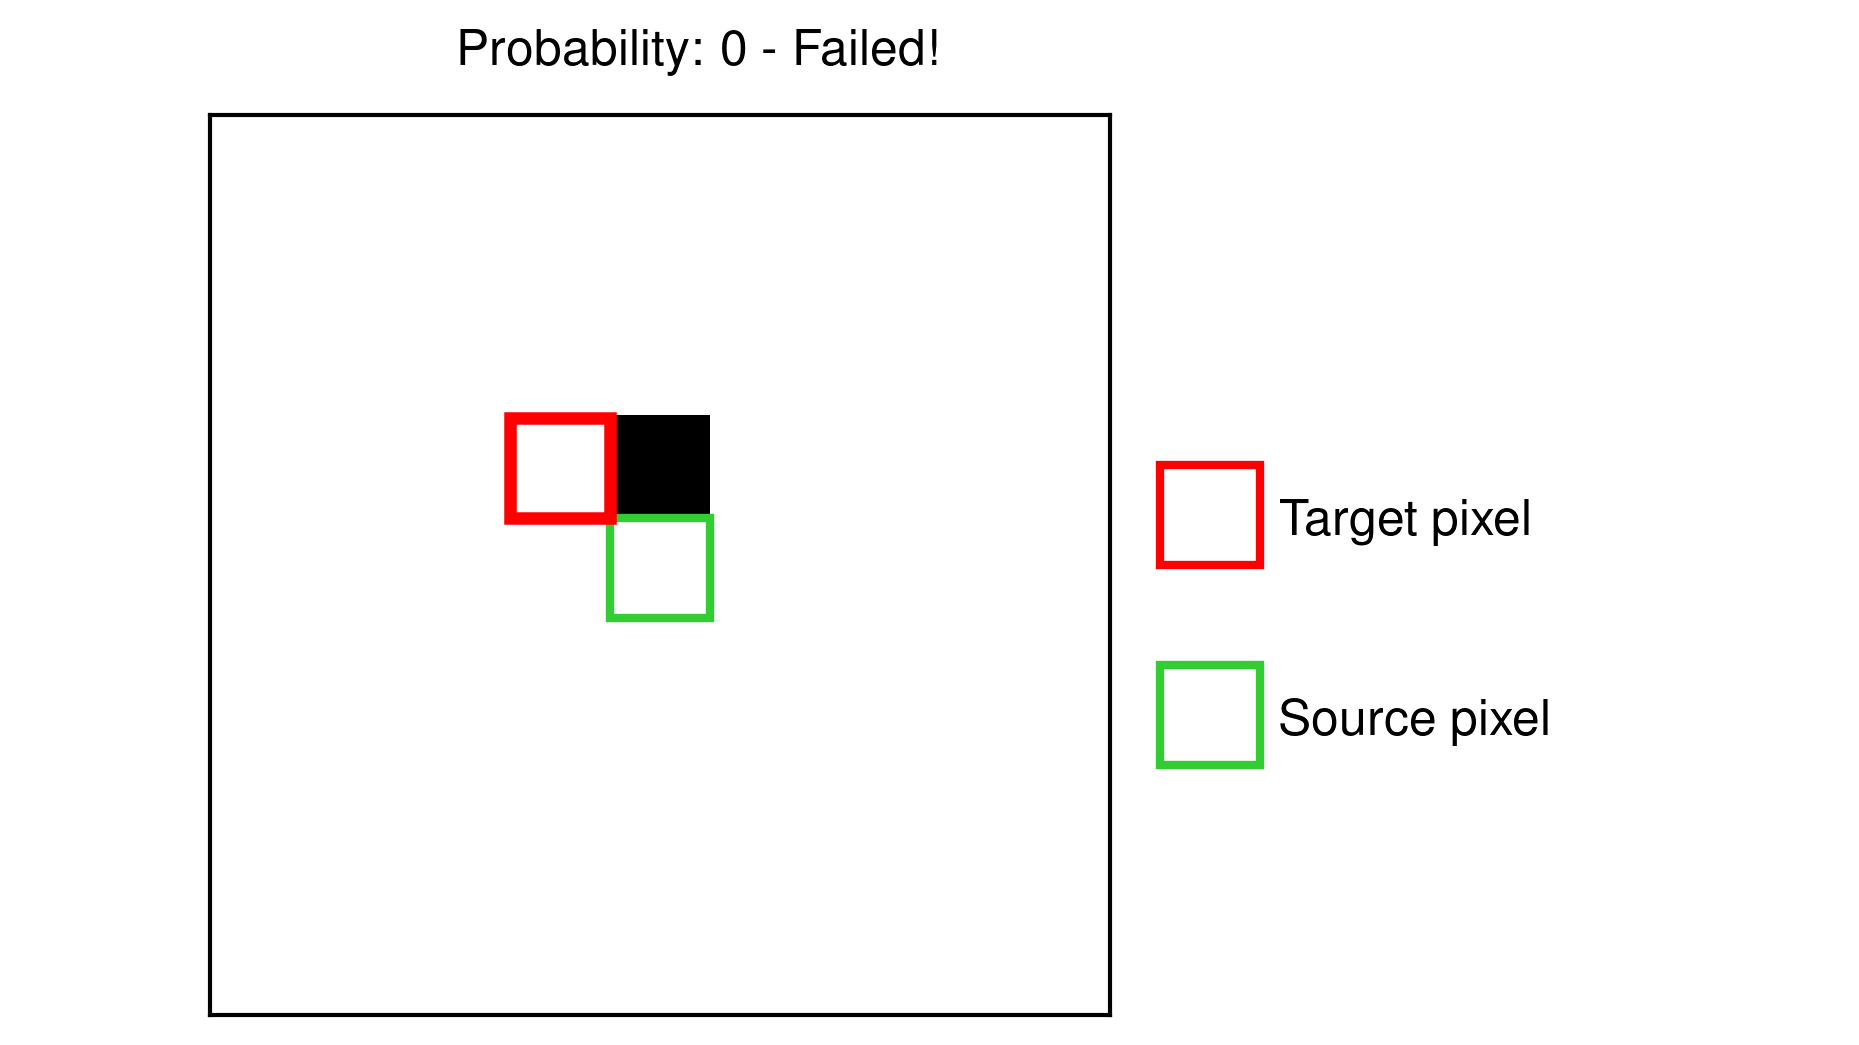

In [163]:
from tqdm import tqdm 
fig = plt.figure(figsize=(6,3), dpi=300)
#fig.add_axes([0,0,1,1])
for i in tqdm(range(100)):
    fig.clf()
    frame = fig.add_axes([0,0,1,1])
    frame.axis("off")
    axs = fig.add_axes([0,0,0.7,1])
    remove_ticklines(axs)
    prev = batch.detach().cpu().clone()
    batch, tgt_coords, src_coords, ret_prob = model(batch, temperature)
    #axs[0].grid(color='black', linewidth=1)
    axs.set_xticks(np.arange(.5, 8.5, 1))
    axs.set_yticks(np.arange(.5, 8.5, 1))
    rect_src = mpl.patches.Rectangle((src_coords[0,2].cpu()-0.5, src_coords[0,1].cpu()-0.47), width=1, height=1, lw=2, facecolor='none', edgecolor='limegreen')
    rect_tgt = mpl.patches.Rectangle((tgt_coords[0,2].cpu()-0.5, tgt_coords[0,1].cpu()-0.47), width=1, height=1, lw=3, facecolor='none', edgecolor='red')
    axs.imshow(prev[0], cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
    axs.add_patch(rect_src)
    axs.add_patch(rect_tgt)
    msg = "Success!!" if not t.isclose(t.sum(batch),t.sum(prev)) else "Failed!" 
    axs.text(
        2,-1.,
        f"Probability: {ret_prob} - {msg}",
        clip_on=False
    )
    legend_src = mpl.patches.Rectangle((9,5), width=1, height=1, lw=2, facecolor='none', edgecolor='limegreen', clip_on=False)
    legend_tgt = mpl.patches.Rectangle((9,3), width=1, height=1, lw=2, facecolor='none', edgecolor='red', clip_on=False)
    axs.add_patch(legend_src)
    axs.add_patch(legend_tgt)
    axs.text(
        10.2,3.7,
        "Target pixel",
        clip_on=False
    )
    axs.text(
        10.2,5.7,
        "Source pixel",
        clip_on=False
    )
    fig.savefig(f"./images/{i}.png", dpi=300, bbox_inches="tight")

plt.show()

In [166]:
import imageio
from tqdm import tqdm
images = []
for i in tqdm(range(0,100)):
    images.append(imageio.imread(f"./images/{i}.png"))

imageio.mimsave("./vis.gif", images, duration=1.)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\jsche\AppData\Local\Temp\ipykernel_2072\3451720582.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"./images/{i}.png"))
100%|██████████| 100/100 [00:02<00:00, 42.45it/s]


# Results

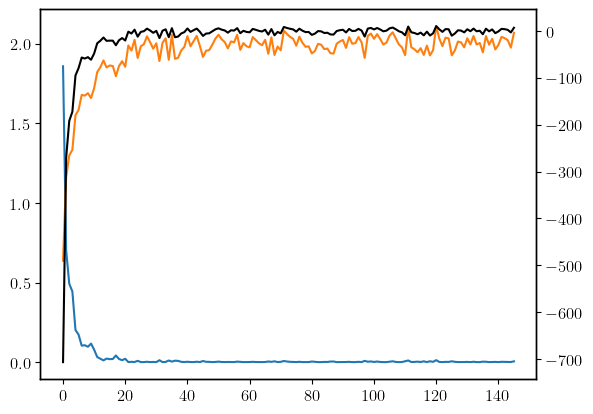

In [4]:
losses = np.load("./results/losses2.npy")
plt.plot(losses)
distances = np.load("./results/distances2.npy")
plt.plot(distances)
ax2 = plt.twinx()
grads = np.load("./results/grads2.npy")
ax2.plot(grads, color="black")

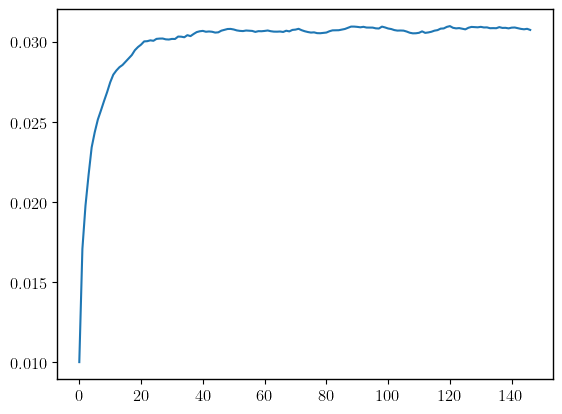

In [6]:
temperatures = np.load("./results/temperatures2.npy")
plt.plot(temperatures)

(147, 1)
(146, 1)


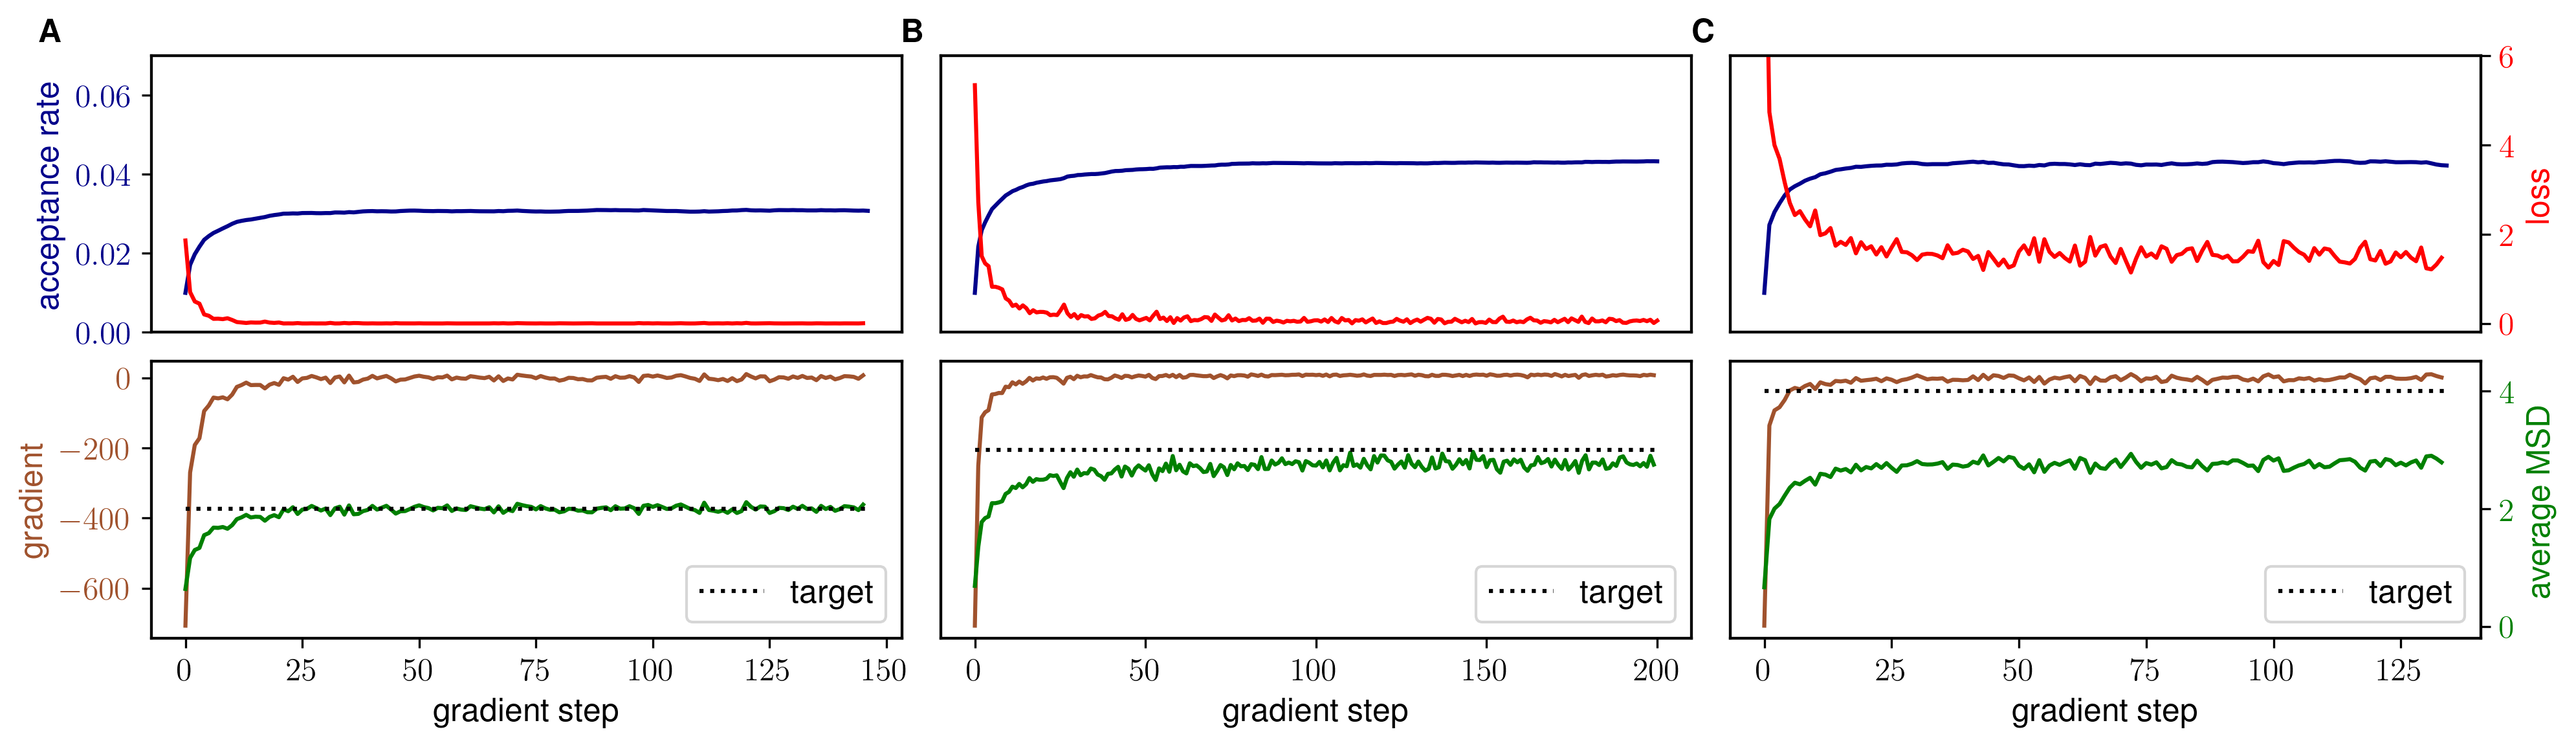

In [36]:
import pandas as pd
fig = plt.figure(figsize=(12,3), layout="constrained", dpi=300)
s_figs = fig.subfigures(2,3, hspace=0.1, wspace=0.05)

s_figs[0,0].text(
        -0.15,1.05,
        r"\textbf{A}"
)
s_figs[0,1].text(
        -0.05,1.05,
        r"\textbf{B}"
)
s_figs[0,2].text(
        -0.05,1.05,
        r"\textbf{C}"
)

n_steps = 200

#####
###
###             [0,0]: Losses and Params 1
###
#####

color = 'darkblue'
ax_00 = s_figs[0,0].add_axes([0,0,1,1])
temperatures = pd.DataFrame(np.load("./results/temperatures2.npy"))
print(temperatures.shape)
ax_00.plot(temperatures, color=color)
ax_00.set_ylabel("acceptance rate", color=color)
ax_00.set_yscale("linear")
ax_00.minorticks_off()
ax_00.tick_params(axis='y', labelcolor=color)

ax_00.set_ylim(0.,0.07)

color = 'r'
ax_00t = ax_00.twinx()
losses = pd.DataFrame(np.load("./results/losses2.npy"))
print(losses.shape)
ax_00t.plot(losses, color=color)


for tic in ax_00.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)        
for tic in ax_00t.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
        
ax_00t.set_ylim(-0.2,6.)

#####
###
###     [1,0]: Gradients and MSDs 1
###
#####

color="sienna"
ax1 = s_figs[1,0].add_axes([0,0,1,1])
grads = pd.DataFrame(np.load("./results/grads2.npy"))
ax1.plot(grads.iloc[:n_steps], color=color)
ax1.set_ylabel("gradient", color=color)
ax1.set_yscale("linear")
ax1.minorticks_off()
#ax1.plot(distances[:n_steps].rolling(10).mean(), color="green")
ax1.tick_params(axis='y', labelcolor=color)

color="green"
ax1_t = plt.twinx()
distances = pd.DataFrame(np.load("./results/distances2.npy"))
#ax1_t.set_ylabel(r"average MSD", color=color)
ax1_t.plot(distances[:n_steps], color="green",)
ax1_t.hlines(y=2, xmin=0,xmax=len(distances), color="black", linestyle="dotted", label="target")
ax1.set_xlabel("gradient step")
for tic in ax1_t.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
        
#ax1_t.set_ylim(-0.1,3.1)
ax1_t.set_ylim(-0.2,4.5)
ax1_t.legend(loc="lower right")

#####
###
###     [0,1]: Losses and param trace 2
###
#####


color = 'darkblue'
ax = s_figs[0,1].add_axes([0.,0,1,1])
temperatures = pd.DataFrame(np.load("./results/temperatures3.npy"))
ax.plot(temperatures.iloc[:n_steps], color=color)
ax.set_yscale("linear")
ax.minorticks_off()
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim(0.,0.07)


color = 'r'
ax_t = ax.twinx()
losses = pd.DataFrame(np.load("./results/losses3.npy"))
ax_t.plot(losses.iloc[:n_steps], color=color)
#ax_t.set_ylabel(r"loss", color=color)
for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
for tic in ax_t.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
ax_t.set_ylim(-0.2,6.)

#####
###
###     [1,1]: Gradients and MSDs 2
###
#####

color="sienna"
ax1_r = s_figs[1,1].add_axes([0,0,1,1])
grads = pd.DataFrame(np.load("./results/grads3.npy"))
ax1_r.plot(grads.iloc[:n_steps], color=color)
#ax1.plot(distances[:n_steps].rolling(10).mean(), color="green")

color="green"
ax1_t = plt.twinx()
distances = pd.DataFrame(np.load("./results/distances3.npy"))
#ax1_t.set_ylabel(r"average MSD", color=color)
ax1_t.plot(distances[:n_steps], color="green",)
ax1_t.hlines(y=3, xmin=0,xmax=200, color="black", linestyle="dotted", label="target")
ax1_r.set_xlabel("gradient step")

for tic in ax1_r.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
for tic in ax1_t.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

ax1_t.set_ylim(-0.2,4.5)

ax1_t.legend(loc="lower right")

#####
###
###     [2,0]: Losses and param trace 3
###
#####


color = 'darkblue'
ax = s_figs[0,2].add_axes([0.,0,1,1])
temperatures = pd.DataFrame(np.load("./results/temperatures4.npy"))
ax.plot(temperatures.iloc[:n_steps], color=color)
ax.set_yscale("linear")
ax.minorticks_off()
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim(0.,0.07)


color = 'r'
ax_t = ax.twinx()
losses = pd.DataFrame(np.load("./results/losses4.npy"))
ax_t.plot(losses.iloc[:n_steps], color=color)
ax_t.set_ylabel(r"loss", color=color)
for tic in ax.xaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)

for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
ax_t.set_ylim(-0.2,6.)
ax_t.tick_params(axis='y', labelcolor=color)

#####
###
###     [2,1]: Gradients and MSDs 3
###
#####

color="sienna"
ax1_r = s_figs[1,2].add_axes([0,0,1,1])
grads = pd.DataFrame(np.load("./results/grads4.npy"))
ax1_r.plot(grads.iloc[:n_steps], color=color)
#ax1.plot(distances[:n_steps].rolling(10).mean(), color="green")
ax1_r.set_xlabel("gradient step")

color="green"
ax1_t = plt.twinx()
distances = pd.DataFrame(np.load("./results/distances4.npy"))
ax1_t.set_ylabel(r"average MSD", color=color)
ax1_t.plot(distances[:n_steps], color="green",)
ax1_t.hlines(y=4, xmin=0,xmax=len(losses), color="black", linestyle="dotted", label="target")
ax1_t.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel("gradient step")

for tic in ax1_r.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
        tic.label1.set_visible(False)
        tic.label2.set_visible(False)
        
ax1_t.set_ylim(-0.2,4.5)


ax1_t.legend(loc="lower right")

plt.show()

(416, 1)


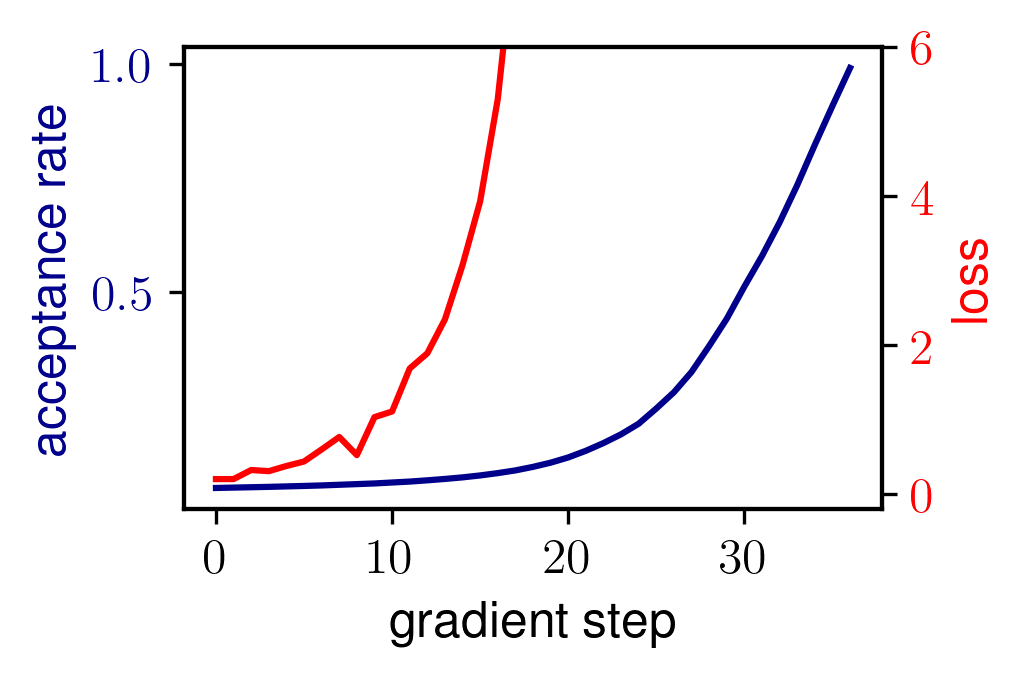

In [45]:
import pandas as pd

fig = plt.figure(figsize=(3,2), dpi=300)

color = 'darkblue'
temperatures = pd.DataFrame(np.load("./results/temperatures4_exp.npy"))
print(temperatures.shape)
plt.plot(temperatures[temperatures<=1], color=color)
plt.ylabel("acceptance rate", color=color)
plt.yscale("linear")
plt.minorticks_off()
plt.tick_params(axis='y', labelcolor=color)
plt.xlabel("gradient step")

color = 'r'
ax_t = plt.twinx()
losses = pd.DataFrame(np.load("./results/losses4_exp.npy"))
ax_t.plot(losses[temperatures<=1], color=color)
ax_t.set_ylabel(r"loss", color=color)
ax_t.set_ylim(-0.2,6.)
ax_t.tick_params(axis='y', labelcolor=color)

plt.show()

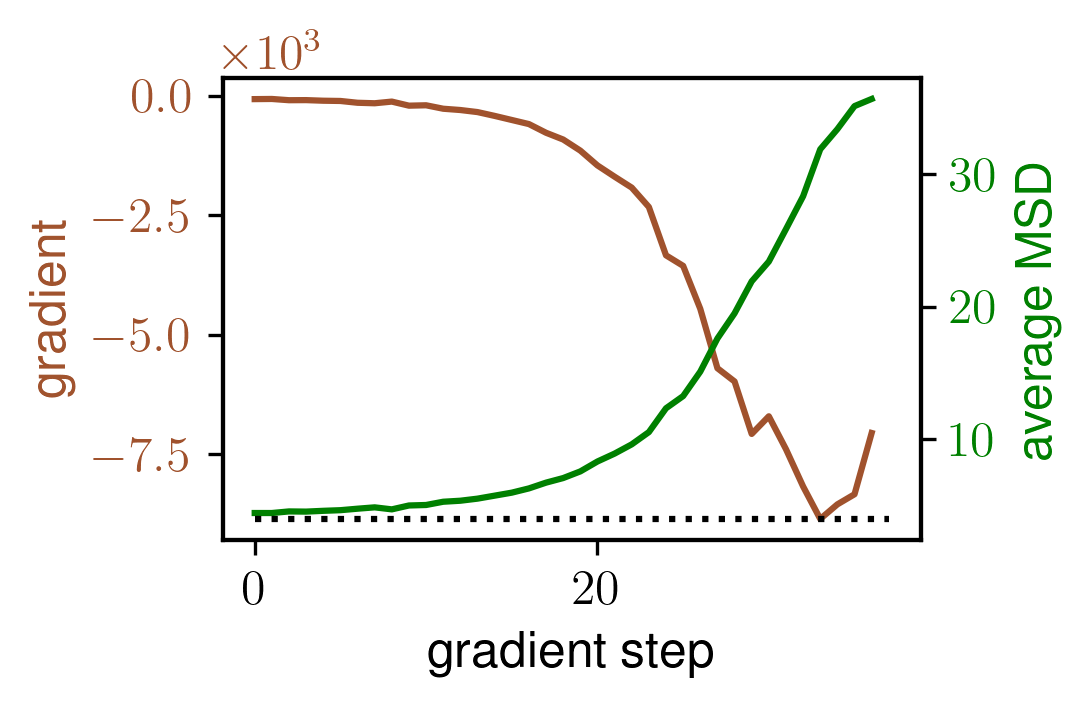

In [44]:
from matplotlib import ticker

fig = plt.figure(figsize=(3,2), dpi=300)

color="sienna"
grads = pd.DataFrame(np.load("./results/grads4_exp.npy"))
plt.plot(grads[temperatures<=1], color=color)
#ax1.plot(distances[:n_steps].rolling(10).mean(), color="green")
plt.xlabel("gradient step")
plt.tick_params(axis='y', labelcolor=color)
plt.ylabel("gradient", color=color)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
plt.gca().yaxis.set_major_formatter(formatter)

color="green"
ax1_t = plt.twinx()
distances = pd.DataFrame(np.load("./results/distances4_exp.npy"))
ax1_t.set_ylabel(r"average MSD", color=color)
ax1_t.plot(distances[temperatures<=1], color="green",)
ax1_t.tick_params(axis='y', labelcolor=color)

ax1_t.hlines(y=4, xmin=0,xmax=37, color="black", linestyle="dotted", label="target")


(416, 1)


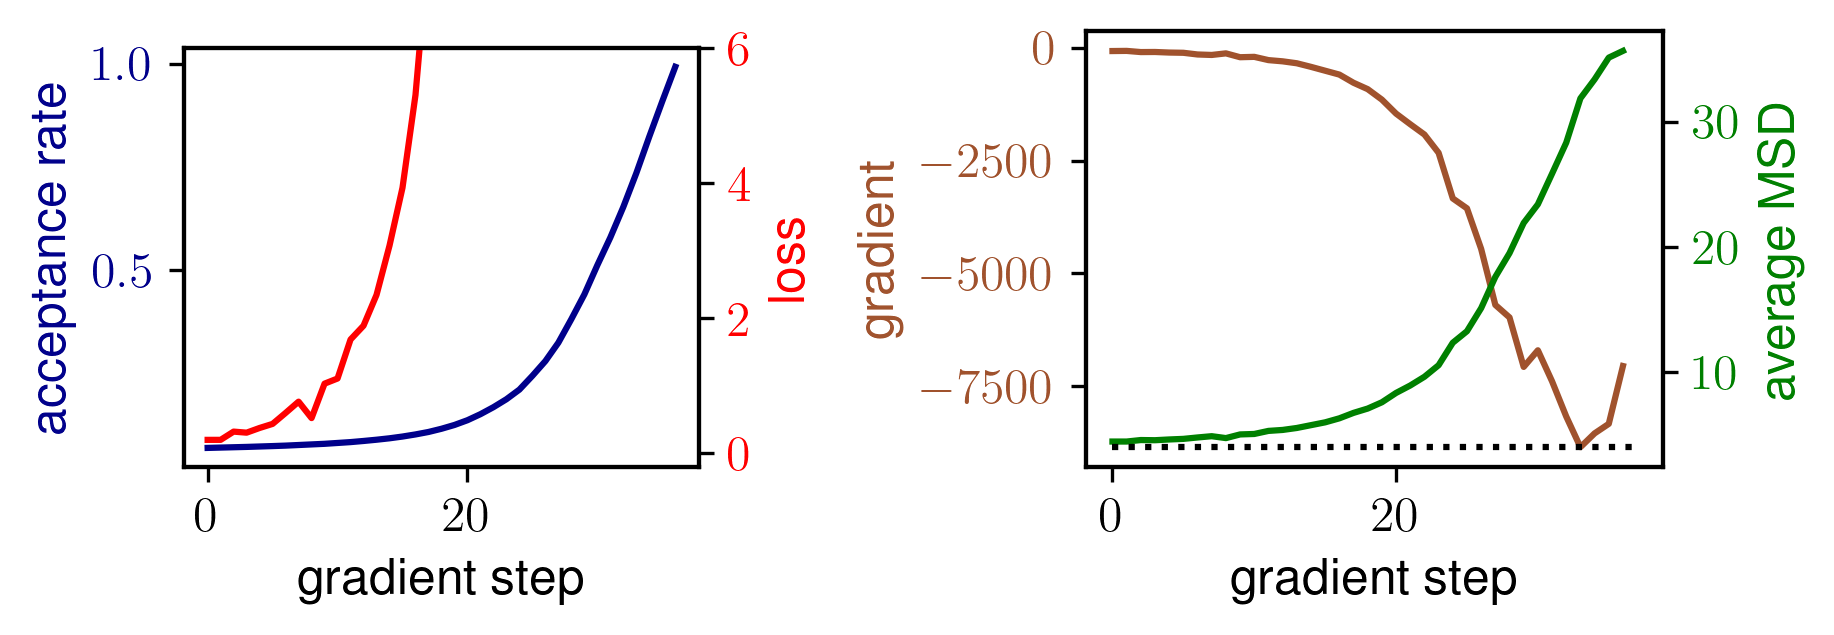

In [59]:
from matplotlib import ticker

fig = plt.figure(figsize=(6,2), layout="constrained", dpi=300)
s_figs = fig.subfigures(1,2, width_ratios=[1,1.2])

color="sienna"
grads = pd.DataFrame(np.load("./results/grads4_exp.npy"))
ax = s_figs[1].subplots()
ax.plot(grads[temperatures<=1], color=color)
#ax1.plot(distances[:n_steps].rolling(10).mean(), color="green")
ax.set_xlabel("gradient step")
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylabel("gradient", color=color)

color="green"
ax1_t = ax.twinx()
distances = pd.DataFrame(np.load("./results/distances4_exp.npy"))
ax1_t.set_ylabel(r"average MSD", color=color)
ax1_t.plot(distances[temperatures<=1], color="green",)
ax1_t.tick_params(axis='y', labelcolor=color)

ax1_t.hlines(y=4, xmin=0,xmax=37, color="black", linestyle="dotted", label="target")

color = 'darkblue'
temperatures = pd.DataFrame(np.load("./results/temperatures4_exp.npy"))
print(temperatures.shape)
ax2 = s_figs[0].subplots()
ax2.plot(temperatures[temperatures<=1], color=color)
ax2.set_ylabel("acceptance rate", color=color)
ax2.set_yscale("linear")
ax2.minorticks_off()
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlabel("gradient step")

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

color = 'r'
ax_t = ax2.twinx()
losses = pd.DataFrame(np.load("./results/losses4_exp.npy"))
ax_t.plot(losses[temperatures<=1], color=color)
ax_t.set_ylabel(r"loss", color=color)
ax_t.set_ylim(-0.2,6.)
ax_t.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(formatter)

plt.show()
